In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation
from IPython.display import HTML,Image
import scipy
from scipy.linalg import lstsq
import warnings
warnings.filterwarnings("ignore")

In [28]:
## . . Your solution to Q3-1 goes here
def awe_2d_explicit_solver_heterogeneous_8th_order(UUo,UUm,dx,dy,dt,v,F,it,sx,sy):
    '''Set up eight-order solver of the acoustic wave equation
    usage: U=awe_2d_explicit_solver_heterogeneous_8th_order(UUo,UUm,dx,dy,dt,v,F,it,sx,sy):
    input:
        UUo: Acoustic pressure vector (nx,ny) at time step n
        UUm: Acoustic pressure vector (nx,ny) at time step n-1
        dx : Spatial sampling in x
        dy : Spatial sampling in y
        dt : Temporal sampling
        v  : Heterogeneous propagation velocity (nx,ny)
        F  : Forcing function (nt)
        it : Time index
        sx : Location of source in x (meters)
        sy : Location of source in y (meters)
    output:
        UUm: Acoustic pressure vector (nx,ny) at time n+1
    dependencies:
        None
    written by Jeff Shragge, jshragge@mines.edu, 10/2019
    '''
    ## . . Get dimensions of wavefield
    nx,ny = np.size(UUo,0),np.size(UUo,1)

    ## . . Define Courant numbers (squared)
    dtdx2,dtdy2 = (dt/dx)**2,(dt/dy)**2

    ## Source location
    isx,isy = int(sx/dx),int(sy/dy) ## . . Force to be integer

    ## . . Inject wavelet
    UUo[isx,isy] += dt*dt*F[it]

    ## . . Update solution
    UUm[4:nx-4,4:ny-4] =  2*UUo[4:nx-4,4:ny-4]-UUm[4:nx-4,4:ny-4]+dtdx2*v[4:nx-4,4:ny-4]**2*(
                    -1/560 *UUo[0:nx-8,4:ny-4]
                    +8/315 *UUo[1:nx-7,4:ny-4]
                    -1/5   *UUo[2:nx-6,4:ny-4]
                    +8/5   *UUo[3:nx-5,4:ny-4]
                    -205/72*UUo[4:nx-4,4:ny-4]
                    +8/5   *UUo[5:nx-3,4:ny-4]
                    -1/5   *UUo[6:nx-2,4:ny-4]
                    +8/315 *UUo[7:nx-1,4:ny-4]
                    -1/560 *UUo[8:nx  ,4:ny-4])+dtdy2*v[4:nx-4,4:ny-4]**2*(
                    -1/560 *UUo[4:nx-4,0:ny-8]
                    +8/315 *UUo[4:nx-4,1:ny-7]
                    -1/5   *UUo[4:nx-4,2:ny-6]
                    +8/5   *UUo[4:nx-4,3:ny-5]
                    -205/72*UUo[4:nx-4,4:ny-4]
                    +8/5   *UUo[4:nx-4,5:ny-3]
                    -1/5   *UUo[4:nx-4,6:ny-2]
                    +8/315 *UUo[4:nx-4,7:ny-1]
                    -1/560 *UUo[4:nx-4,8:ny  ])

    return UUm ## . . Return updated wavefield at time step n+1

#plt.plot(gathers[0][0])
def normalize(data):
  return data/np.max(np.abs(data))

def plot(data, step = 0, delta_t=1, scale =1 ):
  t = np.arange(0, len(data)) * delta_t
  plt.plot(t, data/np.max(np.abs(data)) * scale + step)

def firstBreak(geophone, dt, threshold = 1*10**(-10)):
    indBreak = None  # Initialize with None to handle cases where no break is found
    gp = normalize(geophone)
    #gp = geophone
    for i in range(len(gp)-3):
        if abs(gp[i]-gp[i+1]) > threshold:
            indBreak = i  # Assign the index directly instead of a list
            break
    return indBreak*dt


def downsample(array, new_shape):
    """
    Downsamples a 2D array by averaging over blocks.
    Args:
        array (ndarray): Original 2D array.
        new_shape (tuple): Desired shape (rows, cols) for the downsampled array.
    Returns:
        ndarray: Downsampled 2D array.
    """
    m, n = array.shape
    y, x = new_shape
    if m % y != 0 or n % x != 0:
        raise ValueError("New shape must be a factor of the original shape.")
    # Reshape and average over blocks
    array = array.reshape(y, m // y, x, n // x).mean(axis=(1, 3))
    return array

def gLine(cMat):
    sM = cMat #*1/vMat
    return sM.flatten()

def calculate_differences():
    global dx, dz  # Declare these variables as global
    dx = int(x[1] - x[0])
    dz = int(z[1] - z[0])

def firstBreaks(gathers, dt, threshold = 1*10**(-10) ):
  fb = []
  for i in range(len(gathers)):
    for geophone in gathers[i][:]:
      idxBreak = firstBreak(geophone, dt, threshold)
      fb.append(idxBreak)
  return fb

def G_opp(xStach,yStach,dStach,invModel,lx,lz):
  G = []

  for indx in range(len(xStach)):
      for station in range(len(xStach[indx])):
          rX =xStach[indx][station]
          rY =yStach[indx][station]
          dl = dStach[indx][station]
          cM = rayCountM(rX,rY,dl, invModel.shape, lx//20, lz//20)
          g = gLine(cM)
          G.append(g)

  G = np.matrix(G)
  return G

def ray(sx, sz, rx, rz, n_points=200):
    """
    Generate ray path between source (sx, sz) and receiver (rx, rz).
    """
    distance = np.sqrt((sx - rx)**2 + (sz - rz)**2)
    dL = np.linspace(0, distance, n_points)

    x = sx - dL * (sx - rx) / distance  # Parametric x
    y = sz - dL * (sz - rz) / distance  # Parametric y

    return x, y , dL[1]-dL[0]

def generateRays(sz_values,rSteps,sx,rx):
  xStach, yStach , dStach =[],[],[]
  sxList = np.ones(len(rSteps))*sx*dx
  rxList=  np.ones(len(rSteps))*rx*dx
  rzList = rSteps*dz

  for stepZ in sz_values:
    szList = np.ones(len(rSteps))*stepZ*dz
    xList,yList, dl = ray(sxList,szList,rxList,rzList)
    xStach.append(xList.T)
    yStach.append(yList.T)
    dStach.append(dl.T)

  return xStach, yStach, dStach


def rayDensity(xStach,yStach,dStach,invModel,lx,lz):
  rDm = np.zeros_like(invModel)

  for indx in range(len(xStach)):
      for station in range(len(xStach[indx])):
          rX =xStach[indx][station]
          rY =yStach[indx][station]
          dl = dStach[indx][station]
          cM = rayCountM(rX,rY,dl, invModel.shape, lx//20, lz//20)
          cM = np.where(cM>0,1,0)
          rDm = rDm + cM
  return rDm

def rayCountM(ray_x, ray_y, dStep, grid_shape, xStep, zStep):
    """
    Calculate a matrix with counts of ray path points in each grid cell.

    Args:
        ray_x (ndarray): X-coordinates of the ray path points.
        ray_y (ndarray): Y-coordinates of the ray path points.
        grid_shape (tuple): Shape of the grid (rows, cols).
        dx (float): Cell width of the downsampled grid.
        dz (float): Cell height of the downsampled grid.

    Returns:
        ndarray: A 2D matrix with counts of points in each grid cell.
    """
    # Initialize the count matrix
    count_matrix = np.zeros(grid_shape, dtype=int)

    # Map ray path points to grid indices
    x_indices = (ray_x / xStep).astype(int)
    y_indices = (ray_y / zStep).astype(int)

    # Clip indices to ensure they fall within the grid bounds
    #x_indices = np.clip(x_indices, 0, grid_shape[1]-1 )  # Columns
    #y_indices = np.clip(y_indices, 0, grid_shape[0]-1 )  # Rows


    #x_indices = np.minimum(x_indices, grid_shape[1]-1 )  # Columns
    #y_indices = np.minimum(y_indices, grid_shape[0]-1 )  # Rows

    # Increment counts for each point in the ray path
    for xi, yi in zip(x_indices, y_indices):
        count_matrix[yi, xi] += 1

    return count_matrix * dStep

def regMatrix(grid):
    """
    Create a regularization matrix for a given 2D grid using a stencil.

    Parameters:
        grid (np.ndarray): A 2D numpy array representing the input grid.

    Returns:
        np.ndarray: The regularization matrix corresponding to the grid.
    """
    rows, cols = grid.shape
    n = rows * cols  # Total number of elements in the flattened grid
    regularization_matrix = np.zeros((n, n))  # Initialize the full regularization matrix

    # Loop through every cell in the grid
    for i in range(rows):
        for j in range(cols):
            idx = i * cols + j  # Flattened index of the current cell

            # Apply stencil logic
            # Center point
            regularization_matrix[idx, idx] = 4

            # Left neighbor
            if j > 0:
                regularization_matrix[idx, idx - 1] = -1
            # Right neighbor
            if j < cols - 1:
                regularization_matrix[idx, idx + 1] = -1
            # Top neighbor
            if i > 0:
                regularization_matrix[idx, idx - cols] = -1
            # Bottom neighbor
            if i < rows - 1:
                regularization_matrix[idx, idx + cols] = -1



    return regularization_matrix

import numpy as np

def regMatrix2(grid):
    """
    Create a regularization matrix for a given 2D grid using a stencil.

    Parameters:
        grid (np.ndarray): A 2D numpy array representing the input grid.

    Returns:
        np.ndarray: The regularization matrix corresponding to the grid.
    """
    rows, cols = grid.shape
    n = rows * cols  # Total number of elements in the flattened grid
    regularization_matrix = np.zeros((n, n))  # Initialize the full regularization matrix

    # Loop through every cell in the grid
    for i in range(rows):
        for j in range(cols):
            idx = i * cols + j  # Flattened index of the current cell

            # Apply stencil logic
            # Center point
            if i < rows - 1 and j > 0 and j < cols - 1:
                regularization_matrix[idx, idx] = 4
            # Left neighbor
                regularization_matrix[idx, idx - 1] = -1
            # Right neighbor
                regularization_matrix[idx, idx + 1] = -1
            # Top neighbor
                regularization_matrix[idx, idx - cols] = -1
            # Bottom neighbor
                regularization_matrix[idx, idx + cols] = -1

    return regularization_matrix





# VMAP


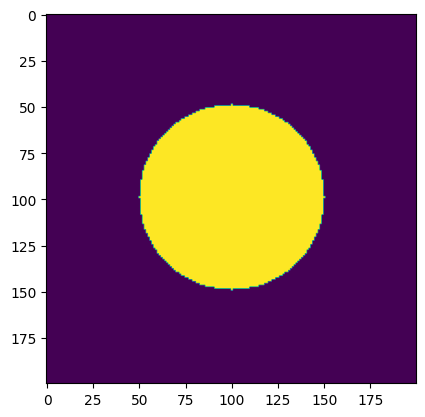

In [29]:

# Define dimensions of the field
lx, lz  = 1000, 1000 # m
nx, nz  = 200, 200
x = np.linspace(0, lx, nx)
z = np.linspace(0, lz, nz)

def calculate_differences():
    global dx, dz  # Declare these variables as global
    dx = int(x[1] - x[0])
    dz = int(z[1] - z[0])

calculate_differences()

# Stations


# Define velocity values
velocity_blue = 1000  # m/s for blue region
velocity_circle = 3000  # m/s for circular region

# Initialize a velocity field with the blue region
velocity_field = np.full((nz, nx), velocity_blue)

# Define circle properties
circle_center = (nx // 2, nz // 2)
circle_radius = 50

# Apply the circular region with the velocity_circle value
for z in range(nz):
    for x in range(nx):
        if (x - circle_center[0]) ** 2 + (z - circle_center[1]) ** 2 <= circle_radius ** 2:
            velocity_field[z, x] = velocity_circle


newvel = np.zeros((nz,nx))
newvel = velocity_field[::-1,:]

plt.imshow(newvel)
plt.show()




In [30]:
## . . Set up solution
## . . Init wavefields on spatial grid
UUo,UUm  = np.zeros((nx,nz)),np.zeros((nx,nz))

## Time stepping parameters
CC = 0.5                   # . . Courant #
nt = 1000                     # . . Number of time steps
dt = CC*dx/np.max(newvel)    # . . Define dt based on Courant
t  = np.linspace(0,nt*dt,nt) # . . Time lin
t0 = 0.05                    # . . Wavelet shift

## . . Define forcing function
ss=0.01                      # . . sigma for Ricker wavelet
F = (1-((t-t0)/ss)**2)*np.exp(-(t-t0)**2/(2*ss**2))

## . . Define source location
Lz, Lx = nz*dz, nx*dx       # . . Model size (in physical m units)


## . . Total Solution space
ggg = np.zeros((nx,nz,nt))
## . . Iterate over solution
# Loop over sz values, moving by 20 indices from the top to the bottom

#sz_values = np.arange(100, 300, 20)  # Update sz by 20 indices from 0 to nz
sx = 5
rx = 195
sz_values = np.arange(5,195,7)
rSteps = np.arange(5, 195, 2)  # Update sz by 20 indices from 0 to nz

gathers = []

for sz_step in sz_values:
    print(f"Running simulation for sz = {sz_step}")
    # Initialize wavefields for each sz
    UUo, UUm = np.zeros((nx, nz)), np.zeros((nx, nz))
    ggg = np.zeros((nx, nz, nt))  # Solution space for current sz

    # Time-stepping loop
    for it in range(nt):
        tmp = awe_2d_explicit_solver_heterogeneous_8th_order(UUo, UUm, dx, dz, dt, newvel, F, it, sx*dx, sz_step*dz)
        ggg[:, :, it] = tmp  # Save the solution
        UUm = UUo  # Prepare for next iteration
        UUo = tmp  # Update solution at the next time step

    shot_gather = []
    for step in rSteps:
      geophone = ggg[rx,step,:]
      shot_gather.append(geophone)

    gathers.append(shot_gather)

    # Save the ggg array for the current sz step as an .npz file
    #filename = f"sz_{sz_step}.npz"
    #np.savez_compressed(filename, ggg=ggg)
    #print(f"Saved simulation data to {filename}")




Running simulation for sz = 5
Running simulation for sz = 12
Running simulation for sz = 19
Running simulation for sz = 26
Running simulation for sz = 33
Running simulation for sz = 40
Running simulation for sz = 47
Running simulation for sz = 54
Running simulation for sz = 61
Running simulation for sz = 68
Running simulation for sz = 75
Running simulation for sz = 82
Running simulation for sz = 89
Running simulation for sz = 96
Running simulation for sz = 103
Running simulation for sz = 110
Running simulation for sz = 117
Running simulation for sz = 124
Running simulation for sz = 131
Running simulation for sz = 138
Running simulation for sz = 145
Running simulation for sz = 152
Running simulation for sz = 159
Running simulation for sz = 166
Running simulation for sz = 173
Running simulation for sz = 180
Running simulation for sz = 187
Running simulation for sz = 194


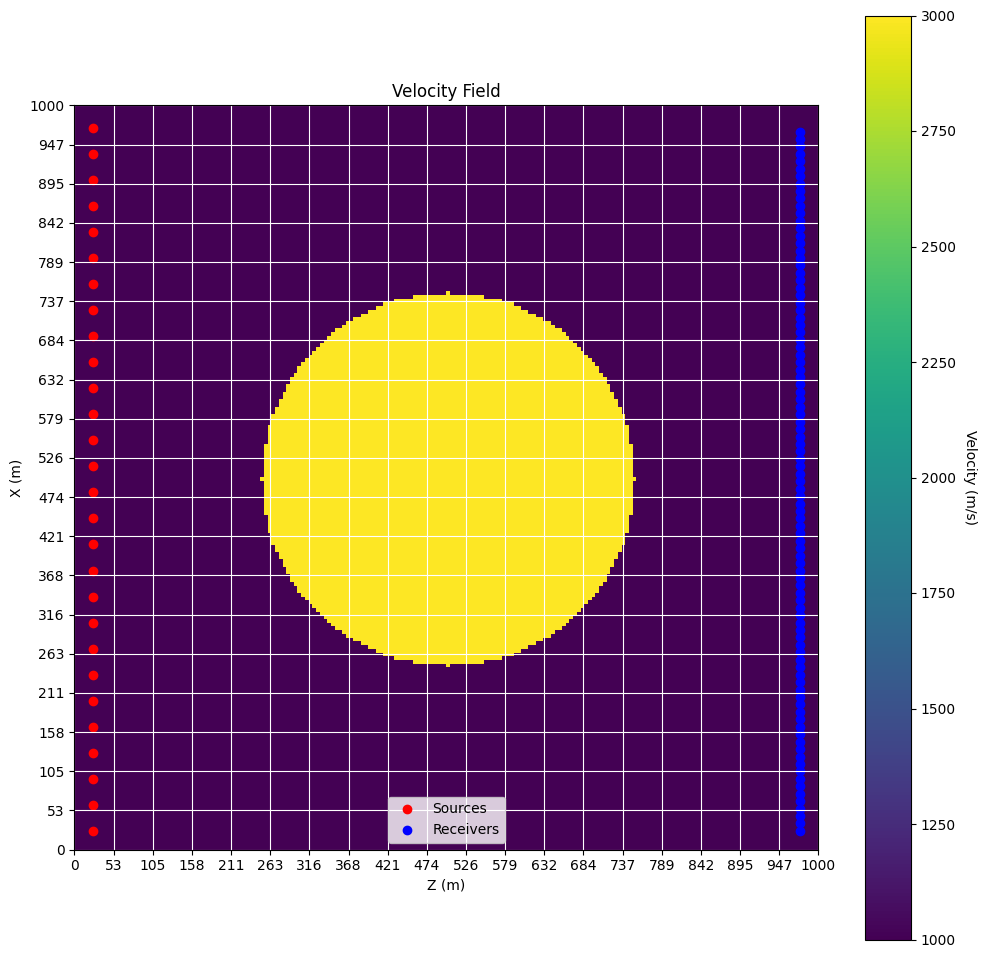

In [31]:
# Display the velocity field
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
im = ax.imshow(velocity_field, cmap='viridis', origin='upper', extent=(0, lx, 0, lz))

# Add a colorbar for the velocity field
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Velocity (m/s)', rotation=270, labelpad=15)

# Sx, Rx points
ax.scatter(np.ones(len(sz_values)) * sx * dx, sz_values * dz, marker='o', color='red', label='Sources')
ax.scatter(np.ones(len(rSteps)) * rx * dx, rSteps * dz, marker='o', color='blue', label='Receivers')

# Grid spacing
ticks = np.linspace(0, lx, 20)
ax.grid(color='white')

ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xlabel('Z (m)')
ax.set_ylabel('X (m)')
ax.set_title('Velocity Field')
ax.legend()

plt.show()


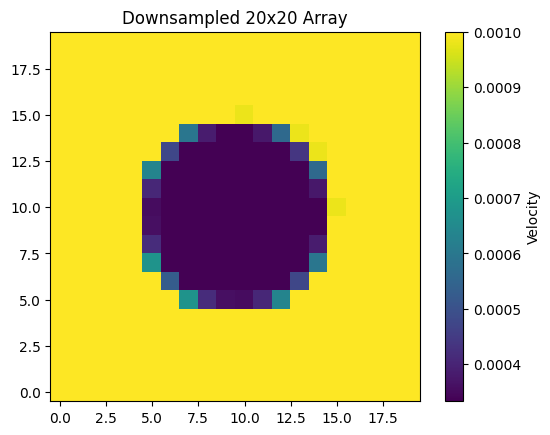

In [32]:
# Downsample to 20x20
invModel = downsample(velocity_field, (20, 20))

# Plot the result
plt.imshow(1/invModel, cmap='viridis', origin='lower')
plt.colorbar(label='Velocity')
plt.title('Downsampled 20x20 Array')
plt.show()

In [33]:
xFS,yFS,dFS = generateRays(sz_values,rSteps,sx,rx)
#rx = 195
fb = firstBreaks(gathers, dt, threshold = 1e-4)
# matrix
dFB = np.matrix(fb).T

xS,yS,dS = generateRays(sz_values,rSteps,sx,rx)
G = G_opp(xS,yS,dS,invModel,lx,lz)

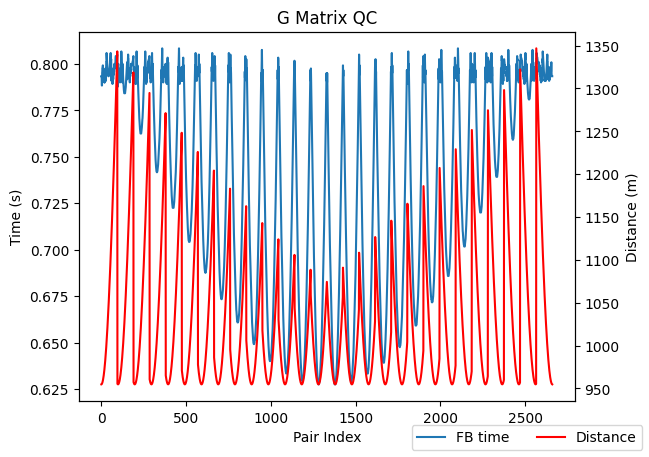

In [34]:
fig, ax1 = plt.subplots()

# Plot the primary axis
line1, = ax1.plot(fb, label='FB time')
ax1.set_ylabel('Time (s)')
ax1.set_xlabel('Pair Index')

# Create a twin axis for the secondary plot
ax2 = ax1.twinx()
line2, = ax2.plot(np.sum(G, axis=1), color='r', label='Distance')
ax2.set_ylabel('Distance (m)')

# Combine legends from both axes
lines = [line1, line2]
labels = [line.get_label() for line in lines]
fig.legend(lines, labels, loc='lower right', ncol=2)  # Adjust location and number of columns as needed

plt.title('G Matrix QC')
plt.show()

954.7738693467335

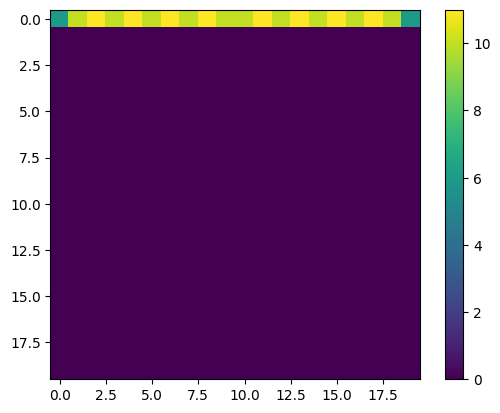

In [35]:
cm = rayCountM(xS[0][0],yS[0][0],dS[0][0], invModel.shape ,lx/20,lz/20)
plt.imshow(cm/dS[0][0])
plt.colorbar()
np.sum(cm)


Text(0.5, 0, 'X index')

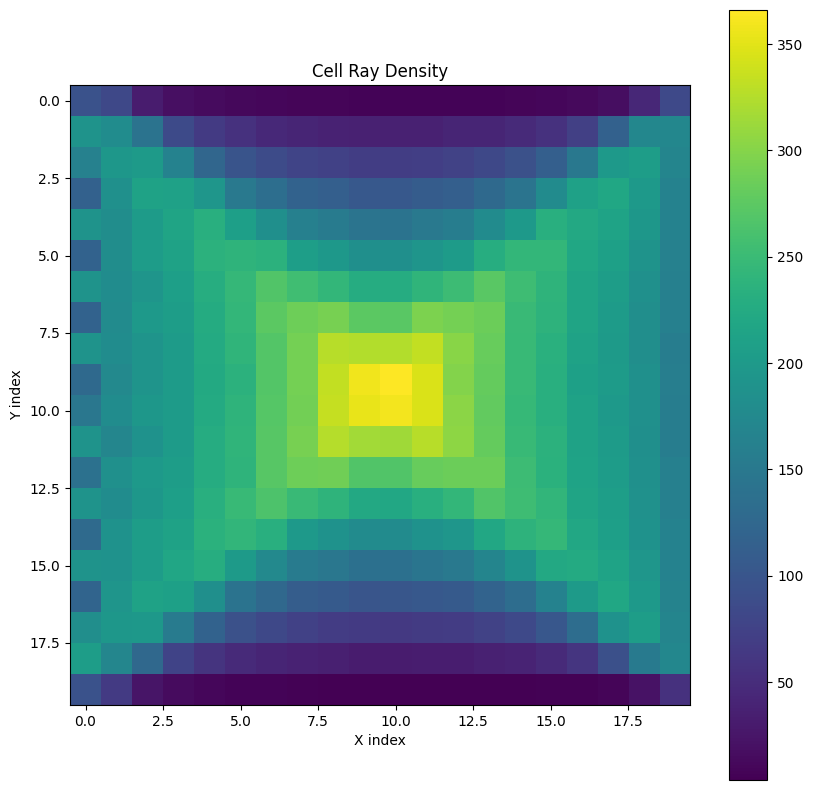

In [36]:
rDM = rayDensity(xS,yS,dS,invModel,lx,lz)
plt.figure(figsize=(10,10))
plt.imshow(rDM)
plt.colorbar()
plt.title('Cell Ray Density')
plt.ylabel('Y index')
plt.xlabel('X index')

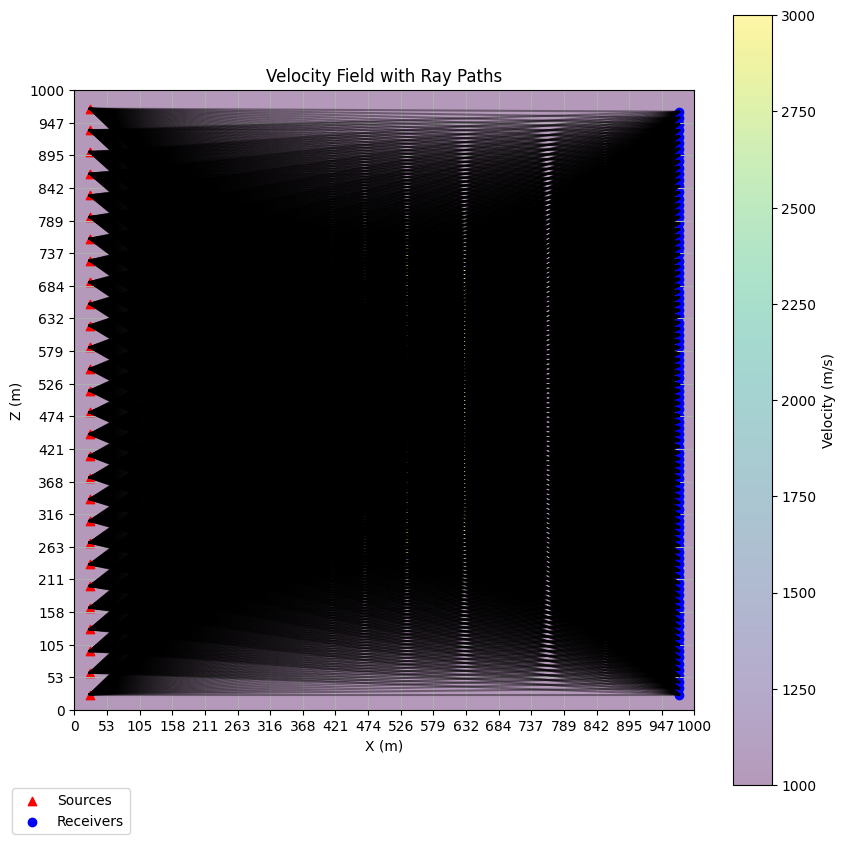

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot the velocity field
im = ax.imshow(velocity_field, cmap='viridis', origin='upper', extent=(0, lx, 0, lz), alpha=0.4)

# Set axis labels
ax.set_xlabel('X (m)')
ax.set_ylabel('Z (m)')

# Overlay ray paths
for i in range(len(sz_values)):
    for j in range(len(rSteps)):
        ax.plot(xS[i][j], yS[i][j], color='black', alpha=0.4)

ax.scatter(np.ones(len(sz_values))*sx*dx, sz_values*dz, marker='^', color='red', label='Sources')
ax.scatter(np.ones(len(rSteps))*rx*dx, rSteps*dz, marker='o', color='blue', label='Receivers')

# Set ticks
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.grid()

# Add colorbar
cbar = fig.colorbar(im, ax=ax, label='Velocity (m/s)')
ax.legend(loc='lower left', bbox_to_anchor=(-.1, -.2), borderaxespad=0)
plt.title('Velocity Field with Ray Paths')
plt.show()



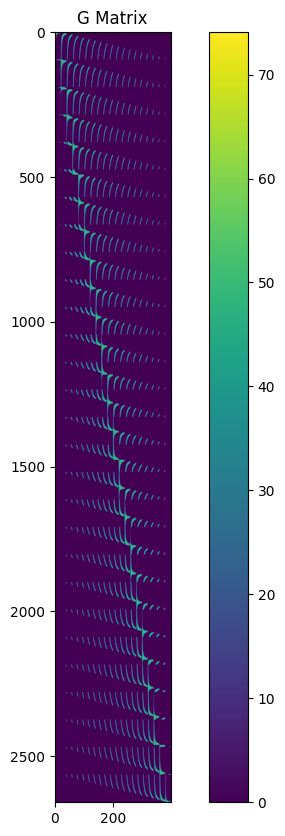

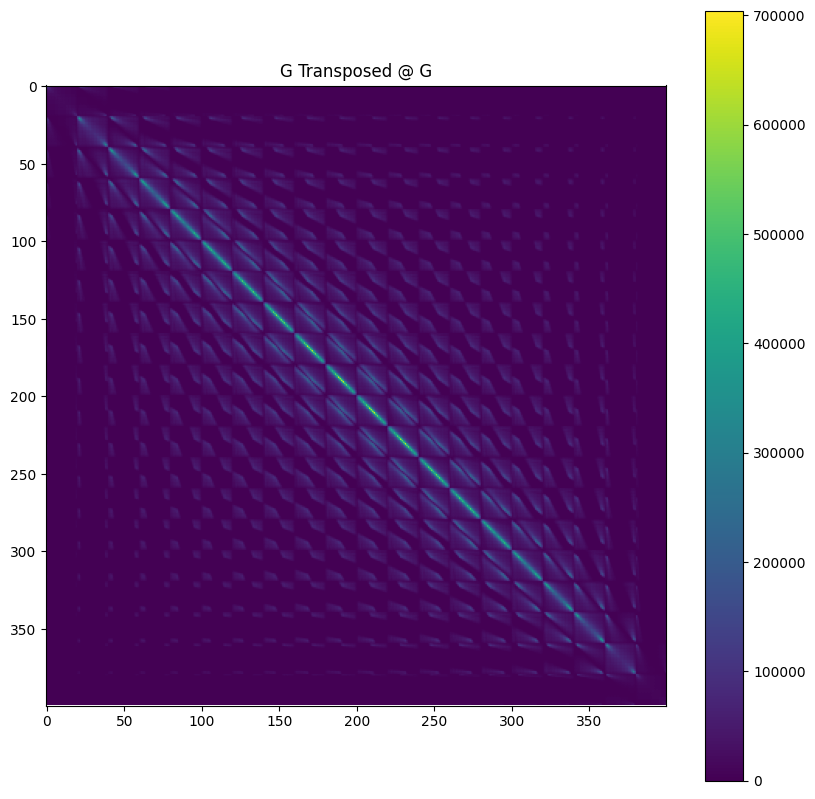

In [38]:
plt.figure(figsize=(10,10))
plt.imshow(G)
plt.colorbar()
plt.title('G Matrix')
plt.figure(figsize=(10,10))
plt.imshow(G.T@G)
plt.title('G Transposed @ G')
plt.colorbar()

Text(0.5, 1.0, 'Regularization Matrix')

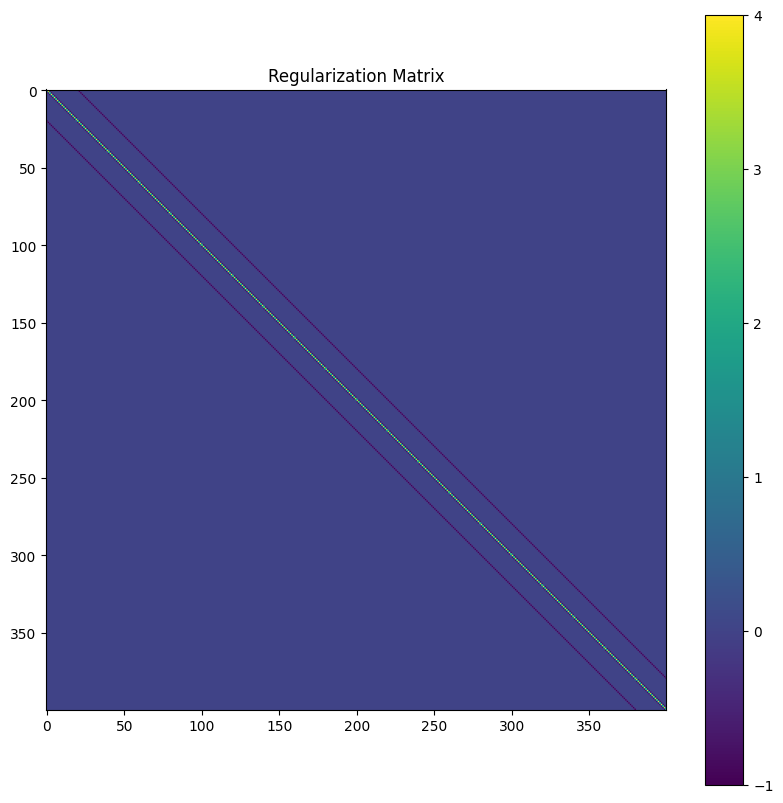

In [39]:
# Regularization Matrix
plt.figure(figsize=(10,10))
rM = regMatrix(invModel)
plt.imshow(rM)
plt.colorbar()
plt.title('Regularization Matrix')

In [40]:
rM.shape, G.shape, dFB.shape

((400, 400), (2660, 400), (2660, 1))

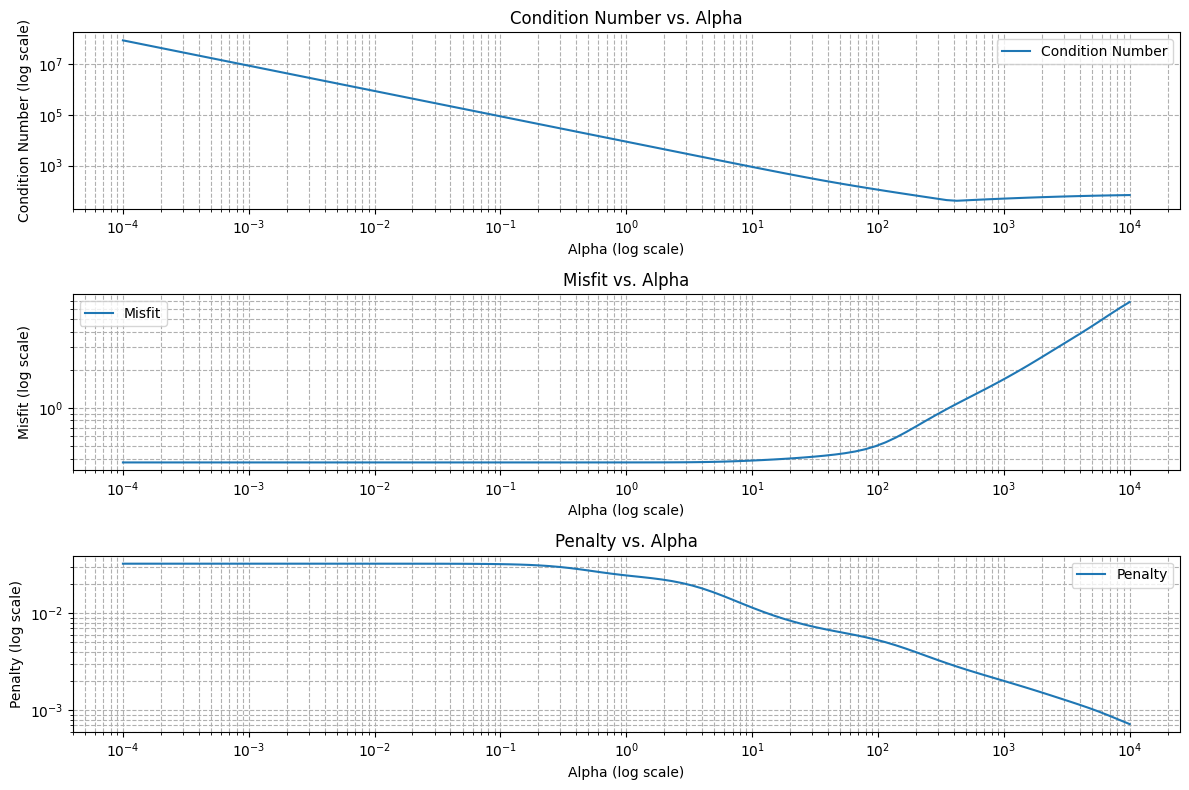

In [41]:
import numpy as np
import matplotlib.pyplot as plt

def plot_condition_numbers_and_metrics(G, rM, dFB, alphas):
    """
    Plots condition numbers, misfits, and penalties as a function of alpha.

    Parameters:
    G (ndarray): Forward matrix
    rM (ndarray): Regularization matrix
    dFB (ndarray): Data vector
    alphas (ndarray): Range of regularization parameters
    """
    condition_numbers = []
    misfits = []
    penalties = []
    zeros = np.zeros((rM.shape[0], 1))  # Zero vector for regularization term

    for alpha in alphas:
        # Create the problem matrix with regularization
        problemMatrix = np.vstack([G, alpha * rM])
        dataVector = np.vstack([dFB, zeros])

        # Calculate condition number
        cond_num = np.linalg.cond(problemMatrix)
        condition_numbers.append(cond_num)

        # Solve for m using least squares
        m, _, _, _ = np.linalg.lstsq(problemMatrix, dataVector, rcond=None)

        # Compute misfit and penalty
        misfit = np.linalg.norm(G @ m - dFB)  # Data misfit
        penalty = np.linalg.norm(rM @ m)     # Regularization penalty
        misfits.append(misfit)
        penalties.append(penalty)

    # Plotting
    plt.figure(figsize=(12, 8))

    # Condition number plot
    plt.subplot(3, 1, 1)
    plt.plot(alphas, condition_numbers, label="Condition Number")
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Alpha (log scale)")
    plt.ylabel("Condition Number (log scale)")
    plt.title("Condition Number vs. Alpha")
    plt.legend()
    plt.grid(True, which="both", linestyle="--")

    # Misfit plot
    plt.subplot(3, 1, 2)
    plt.plot(alphas, misfits, label="Misfit")
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Alpha (log scale)")
    plt.ylabel("Misfit (log scale)")
    plt.title("Misfit vs. Alpha")
    plt.legend()
    plt.grid(True, which="both", linestyle="--")

    # Penalty plot
    plt.subplot(3, 1, 3)
    plt.plot(alphas, penalties, label="Penalty")
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Alpha (log scale)")
    plt.ylabel("Penalty (log scale)")
    plt.title("Penalty vs. Alpha")
    plt.legend()
    plt.grid(True, which="both", linestyle="--")

    plt.tight_layout()
    plt.show()

# Define your alpha range
alphas = np.logspace(-4, 4, 100)  # Example range of regularization parameters

# Call the function (replace G, rM, dFB with your actual variables)
# plot_condition_numbers_and_metrics(G, rM, dFB, alphas)
plot_condition_numbers_and_metrics(G, rM, dFB, alphas)


In [42]:
#alpha = 200
alpha = alphas[idx]
zeros = np.zeros((rM.shape[0], 1))  # Zero vector for regularization term

problemMatrix = np.vstack([G, alpha * rM])
dataVector = np.vstack([dFB, zeros])

pM = problemMatrix
dV = dataVector

T1 = pM.T@pM
T2 = np.linalg.inv(T1)
T3 = T2@pM.T

m_inv = T3 @ dV
#m_inv = np.linalg.inv(pM.T@pM)@pM.T@dV

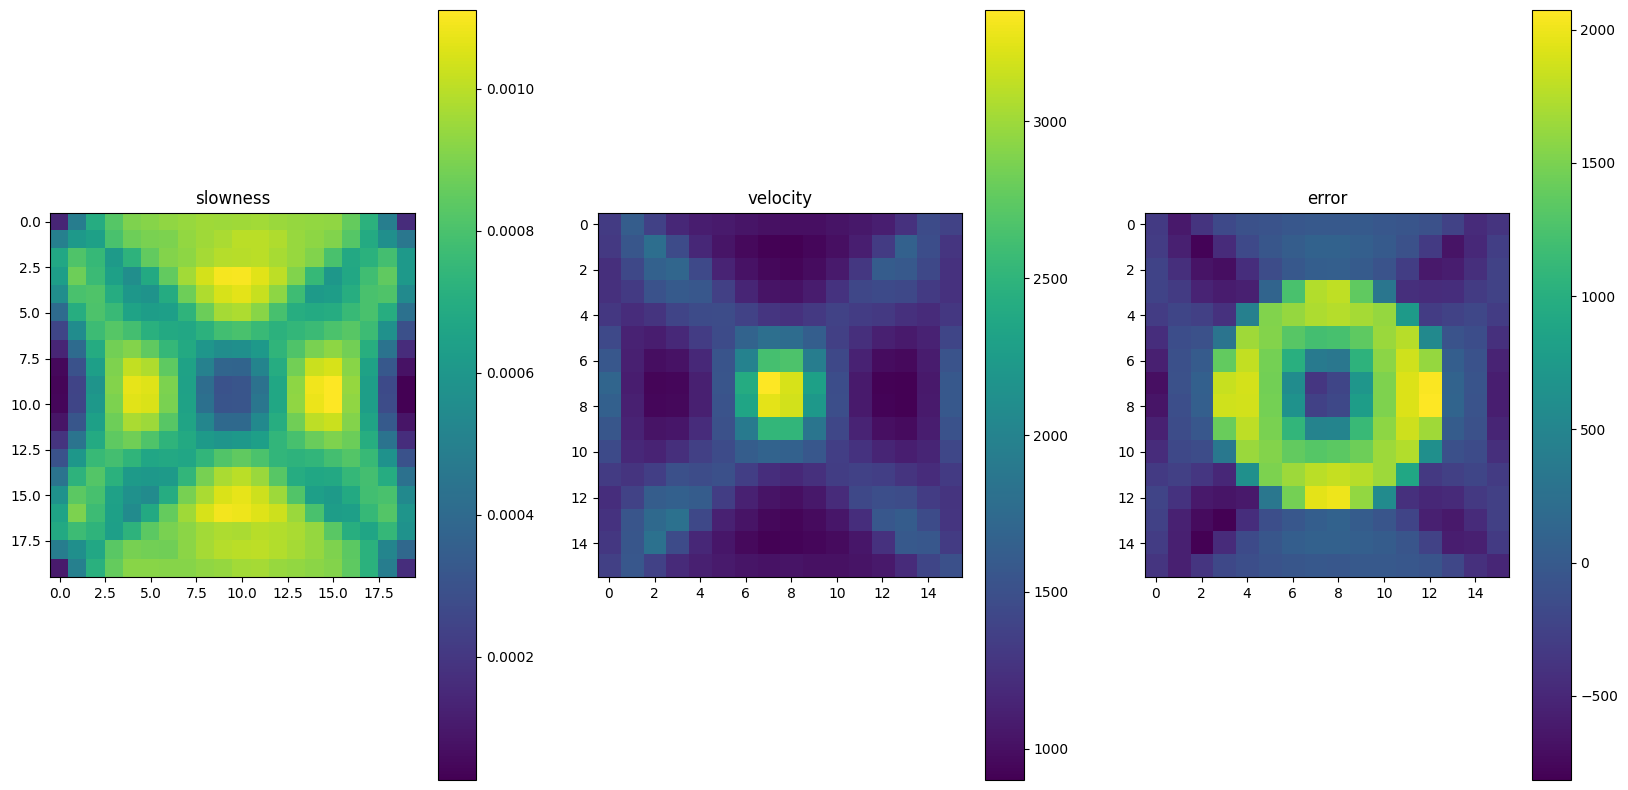

In [43]:
# Plot of each part in the inverse problem, If theres a scaling issue, this is where to find it.
#plt.subplot(1,5,1)
#plt.imshow(T1)#pM.T@pM
#plt.colorbar()
#plt.subplot(1,5,2)
#plt.imshow(T2)# np.linalg.inv(pM.T@pM)
#plt.colorbar()
#plt.subplot(1,5,3)###
#plt.imshow(T3) # np.linalg.inv(pM.T@pM)@pM.T
#plt.colorbar()
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(np.reshape(m_inv,(20,20)))# Slowness Model
plt.title('slowness')
plt.colorbar()
plt.subplot(1,3,2)
velModel =np.reshape(1/m_inv,(20,20))
plt.imshow(velModel[2:-2,2:-2])# Velocity Model

plt.title('velocity')
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(invModel[2:-2,2:-2]-velModel[2:-2,2:-2])
plt.title('error')
plt.colorbar()